In [1]:
import numpy as np

### Creating your own GRN

# Generate the cell lineage first

In [6]:
#!/usr/bin/env python3

import random
import time

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_adjacency_matrix(G):
    return nx.to_numpy_array(G, dtype=int)

def generate_random_cell_cycle(total_nodes=None,
                               min_per_rank=2,
                               max_per_rank=3,
                               min_ranks=1,
                               max_ranks=5,
                               percent=20,
                               master_regulators=0):
    """
    Generate a DAG allowing multiple parents per node.
    - Fixed-N: each potential prior node j < idx has percent% chance to connect.
      Ensure at least one parent for every non-master node.
    - Rank-based: chain first rank; for each new node, each existing node
      j has percent% chance to connect. Ensure at least one parent.
    Returns (G, initial_master_regulator_list).
    """
    random.seed(time.time())
    G = nx.DiGraph()

    # Fixed-N mode
    if total_nodes is not None:
        all_indices = list(range(total_nodes))
        mr_indices = sorted(random.sample(all_indices, master_regulators)) if master_regulators > 0 else []
        dag_indices = [i for i in all_indices if i not in mr_indices]

        G.add_nodes_from(dag_indices)
        for idx, node in enumerate(dag_indices):
            # random parents
            for j in range(idx):
                if random.randint(0, 99) < percent:
                    G.add_edge(dag_indices[j], node)
            # ensure at least one parent
            if idx > 0 and G.in_degree(node) == 0:
                parent = random.choice(dag_indices[:idx])
                G.add_edge(parent, node)
        return G, mr_indices

    # Rank-based mode
    nodes = 0
    ranks = random.randint(min_ranks, max_ranks)
    all_ranks = []
    for r in range(ranks):
        new_nodes = random.randint(min_per_rank, max_per_rank)
        current_rank = list(range(nodes, nodes + new_nodes))
        G.add_nodes_from(current_rank)

        if r == 0:
            # chain first rank
            for i in range(1, len(current_rank)):
                G.add_edge(current_rank[i-1], current_rank[i])

        # random parents from any existing node
        for node in current_rank:
            for j in range(nodes):
                if random.randint(0, 99) < percent:
                    G.add_edge(j, node)
            # ensure at least one parent if not first rank
            if r > 0 and G.in_degree(node) == 0:
                parent = random.choice(all_ranks[-1])
                G.add_edge(parent, node)

        nodes += new_nodes
        all_ranks.append(current_rank)

    return G, []

def visualize_dag(G):
    """Display the DAG with spring layout."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
    nx.draw_networkx(G, pos,
                     node_color='skyblue', node_size=700,
                     edge_color='gray', arrows=True,
                     arrowstyle='-|>', arrowsize=20,
                     font_size=10)
    plt.title("Randomly Generated DAG")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
    """Replace each 1 with a random float in [min_val, max_val]."""
    perturbed = matrix.astype(float).copy()
    ones = np.where(matrix == 1)
    for i, j in zip(*ones):
        perturbed[i, j] = round(random.uniform(min_val, max_val), 1)
    return perturbed

def find_isolated_nodes(G):
    return [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) == 0]

def generate_interactions_from_dag(G,
                                   inhibit_pct=50):
    """
    Build multi-regulator interactions:
      (target, nRegs, [regs], [K], [coop])
    coop is always 2.0; Ks random ± in [0.5,5.0].
    """
    interactions = []
    for v in sorted(G.nodes()):
        regs = list(G.predecessors(v))
        if not regs:
            continue
        Ks = []
        for u in regs:
            mag = round(random.uniform(0.5, 5.0), 2)
            if random.randint(1, 100) <= inhibit_pct:
                mag = -abs(mag)
            Ks.append(mag)
        coops = [2.0] * len(regs)
        interactions.append((v, len(regs), regs, Ks, coops))
    return interactions

def main(mode,
         total_nodes,
         min_per_rank,
         max_per_rank,
         min_ranks,
         max_ranks,
         percent=20,
         inhibit_pct=50,
         master_regulators=0,
         num_celltypes=None):
    """
    mode 'cell': prints & saves adjacency + perturbed matrices
    mode 'gene': prints & and saves multi-reg interactions + master regulator profiles
    Required: total_nodes, min_per_rank, max_per_rank, min_ranks, max_ranks.
    In gene mode: master_regulators, num_celltypes required.
    """
    # validate
    required = {
        'total_nodes': total_nodes,
        'min_per_rank': min_per_rank, 'max_per_rank': max_per_rank,
        'min_ranks': min_ranks, 'max_ranks': max_ranks
    }
    missing = [k for k, v in required.items() if v is None]
    if missing:
        raise ValueError(f"Missing required params: {', '.join(missing)}")
    if mode not in ('cell', 'gene'):
        raise ValueError("mode must be 'cell' or 'gene'")
    if mode == 'gene' and (master_regulators is None or num_celltypes is None):
        raise ValueError("master_regulators and num_celltypes are required in gene mode")

    # generate
    dag, mr_initial = generate_random_cell_cycle(
        total_nodes, min_per_rank, max_per_rank, min_ranks, max_ranks, percent, master_regulators
    )

    visualize_dag(dag)
    print("Isolated Nodes:", find_isolated_nodes(dag))

    if mode == 'cell':
        mat = get_adjacency_matrix(dag)
        print("\nAdjacency Matrix:")
        for row in mat:
            print("\t".join('0' if v == 0 else str(v) for v in row))
        pert = perturb_adjacency_matrix(mat)
        print("\nPerturbed Adjacency Matrix:")
        for row in pert:
            print("\t".join('0' if v == 0 else str(v) for v in row))
        with open("perturbed_matrix.tab", "w") as f:
            for row in pert:
                f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
        print("\nPerturbed matrix written to perturbed_matrix.tab")

    else:
        inters = generate_interactions_from_dag(dag, inhibit_pct)
        with open("gene_interactions.txt", "w") as f:
            for (v, n, regs, Ks, coops) in inters:
                parts = [str(v), str(n)] + [str(r) for r in regs] + [str(k) for k in Ks] + [str(c) for c in coops]
                line = ",".join(parts)
                print(line)
                f.write(line + "\n")
        print("\nGene interactions written to gene_interactions.txt")

        # master regulator profiles
        affs = {u for _, _, regs, _, _ in inters for u in regs}
        targs = {v for v, *_ in inters}
        aff_only = sorted(affs - targs)
        all_mr = sorted(set(mr_initial) | set(aff_only))
        if all_mr:
            with open("master_regulators.txt", "w") as f:
                header = "regulator," + ",".join(f"celltype{i}" for i in range(1, num_celltypes+1))
                print(header)
                f.write(header + "\n")
                for idx in all_mr:
                    expr = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
                    line = f"{idx}," + ",".join(map(str, expr))
                    print(line)
                    f.write(line + "\n")
            print("\nMaster regulators written to master_regulators.txt")

# Example calls:
# main('cell', total_nodes=5, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=5, percent=20)
# main('gene', total_nodes=10, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=5,
#      percent=20, inhibit_pct=50, master_regulators=2, num_celltypes=4)


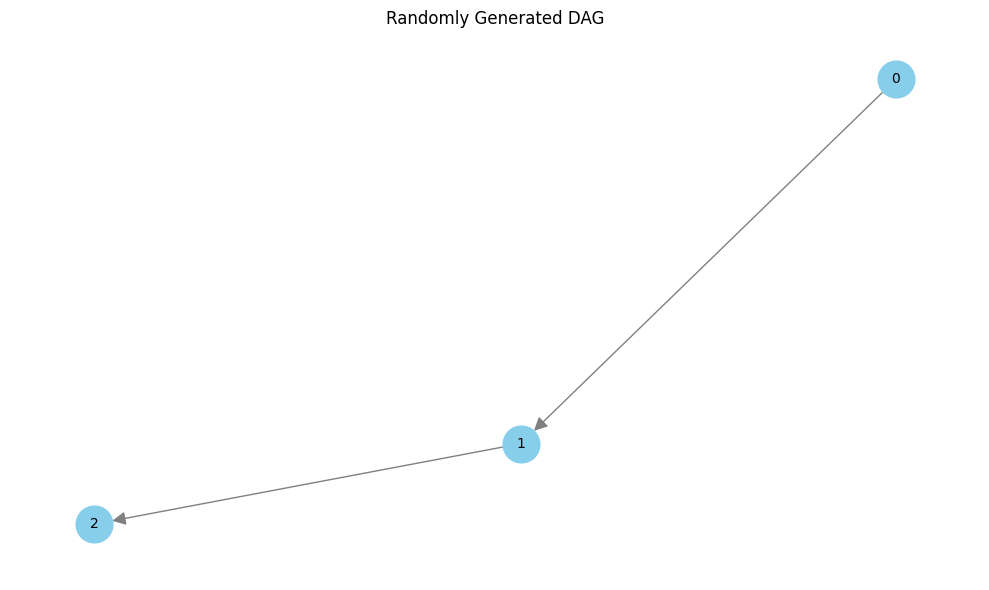

Isolated Nodes: []

Adjacency Matrix:
0	1	0
0	0	1
0	0	0

Perturbed Adjacency Matrix:
0	0.8	0
0	0	0.9
0	0	0

Perturbed matrix written to perturbed_matrix.tab


In [7]:
# import this module, then:
main('cell', total_nodes=3, min_per_rank=1, max_per_rank=4, min_ranks=1, max_ranks=3,percent=20)


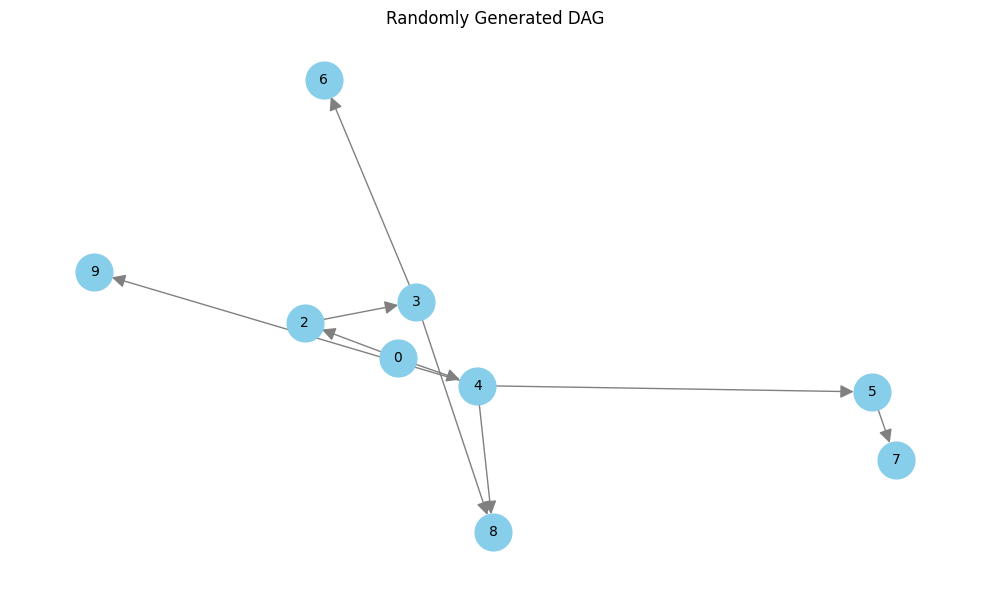

Isolated Nodes: []
2,1,0,-1.49,2.0
3,1,2,-2.4,2.0
4,1,0,3.37,2.0
5,1,4,4.24,2.0
6,1,3,2.01,2.0
7,1,5,2.09,2.0
8,2,3,4,3.05,2.46,2.0,2.0
9,1,4,-3.74,2.0

Gene interactions written to gene_interactions.txt
regulator,celltype1,celltype2,celltype3
0,2.5699,0.1679,2.2602
1,3.7776,2.7425,1.4879

Master regulators written to master_regulators.txt


In [12]:
main('gene', total_nodes=10, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=2, percent=5, inhibit_pct=30, master_regulators=1, num_celltypes=3)